## O2 budget (offline binned in rho2)
Fidelity of offline binnind being assessed, see calc_budget_tracer_rebinned.

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
import rebin_functions as rb
from xhistogram.xarray import histogram
import copy

In [49]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '08990101.heat_salt_o2.1year'
filename = '08990101.ocean_month.nc'
ds = xr.open_dataset(rootdir+runname+'/history/'+filename)
filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid)
# Name of vertical coordinate
vertc = 'zl'

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [50]:
o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2_plus_btm']
o2_tend = o2_terms[0]
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0
for term in o2_terms[:-1]:
    ds[term] *= rho0

# Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
jo2 = ds.jo2_plus_btm - jo2_btm
ds['jo2'] = jo2
o2_terms[-1]='jo2'

# HACK SURFACE FLUX FOR NOW #
ds['o2h_tendency_stf'] = ds['o2h_tendency']-(ds['o2h_tendency_vert_remap']+
                                              ds['o2_advection_xy']+
                                              ds['o2_dfxy_cont_tendency']+
                                              ds['o2_vdiffuse_impl']+
                                              ds['jo2'])

# # HACK SURFACE FLUX FOR NOW #
# ds['o2h_tendency_stf'] = ds['o2h_tendency']
# for term in o2_terms[1:]:
#     ds['o2h_tendency_stf'] -= ds[term]
o2_terms = np.concatenate((o2_terms,['o2h_tendency_stf']))

# Take only o2 budget terms, as well as o2, rhopot2, and thkcello, from dataset
ds_new = ds[o2_terms]
ds_new['o2'] = ds.o2
ds_new['rhopot2'] = ds.rhopot2
ds_new['thkcello'] = ds.thkcello
ds = ds_new.squeeze()

### Calculate global layer integral in rho2 coordinates using xhistogram

In [51]:
prof = rb.total_rebin_layerintegral(ds[o2_terms],
                                    bin_data = ds['rhopot2'],
                                    bins=rho2_i.values,
                                    dim = ['xh','yh','zl'],
                                    area = grid.areacello,
                                    block_size=len(ds['time']),
                                    verbose=True)

o2h_tendency
o2_advection_xy
o2h_tendency_vert_remap
o2_dfxy_cont_tendency
o2_vdiffuse_impl
jo2
o2h_tendency_stf


### Plot the global integral of the tendencies

In [52]:
prof['o2h_tendency']*=-1

(-3000000.0, 3000000.0)

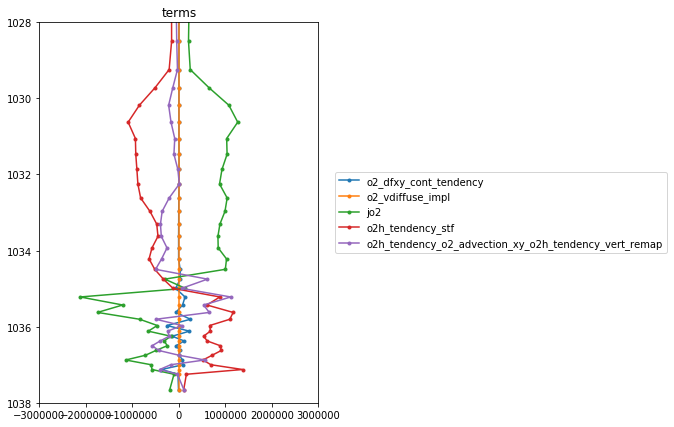

In [66]:
vertc = 'rhopot2_bin'
combine = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap']
bc.plot_budgetterms(prof.mean('time'),o2_terms,vertc=vertc,combine=combine)
plt.gca().set_ylim([1038, 1028])
plt.gca().set_xlim([-3E6,3E6])

### Cumulative sums

In [63]:
prof['o2_material_derivative'] = -1*prof['o2h_tendency']+prof['o2h_tendency_vert_remap']+prof['o2_advection_xy']
# prof_cumsum = prof.sum(dim='rhopot2_bin')-prof.cumsum(dim='rhopot2_bin')
prof_cumsum = prof.sortby('rhopot2_bin',ascending=False).cumsum(skipna=True).assign_coords(rhopot2_bin=np.flipud(prof['rhopot2_bin']))

(1038, 1028)

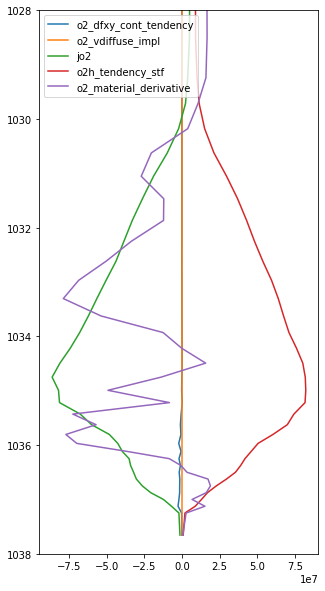

In [67]:
terms = ['o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2','o2h_tendency_stf','o2_material_derivative']
fig,ax=plt.subplots(figsize=(5,10))
for term in terms:
    ax.plot(prof_cumsum[term].mean('time'),prof_cumsum['rhopot2_bin'],label=term)
ax.invert_yaxis()
ax.legend()
ax.set_ylim([1038, 1028])

### Regrid vertical coordinate to rho2 (retaining x and y dimensions)
Including routines for vertical rebinning written by J. Busecke.

In [68]:
rho2_i = xr.open_dataset(rootdir+'history/08500101.ocean_month_rho2.nc').rho2_i
ds_rho2 = rb.total_rebin_layerintegral(ds[o2_terms],
                                    bin_data = ds['rhopot2'],
                                    bins=rho2_i.values,
                                    dim = ['zl'],
                                    area = grid.areacello,
                                    block_size=len(ds['time']),
                                    verbose=True)
# Julius's vertical rebin code
# ds_rho2 = rb.vertical_rebin_wrapper(ds,"rhopot2",rho2_i.values,dz_name="thkcello",vert_dim="zl",verbose=True)

o2h_tendency
o2_advection_xy
o2h_tendency_vert_remap
o2_dfxy_cont_tendency
o2_vdiffuse_impl
jo2
o2h_tendency_stf


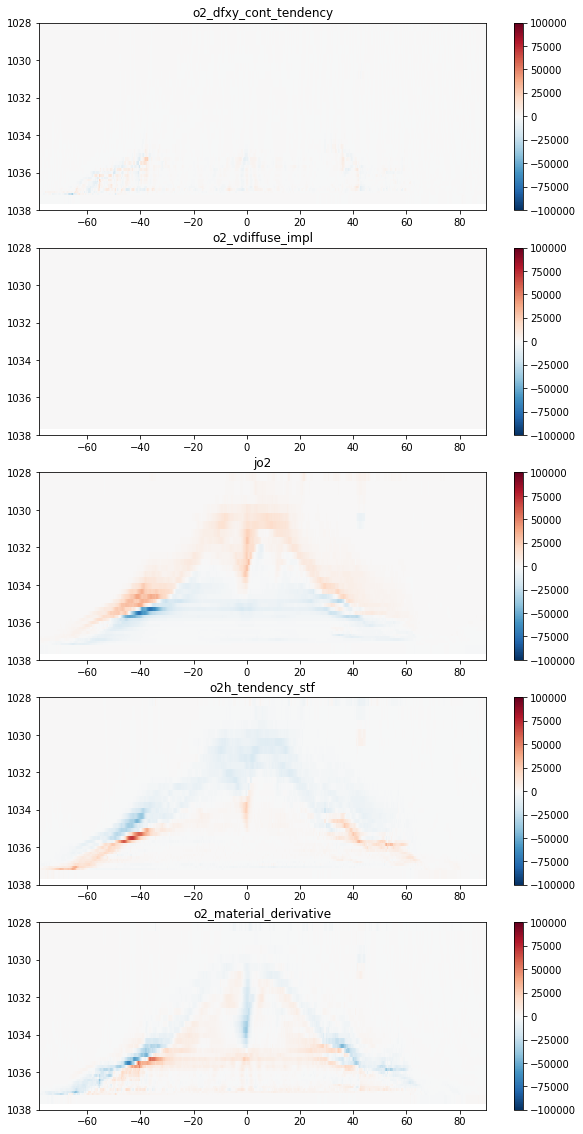

In [75]:
ds_rho2['o2_material_derivative'] = -1*ds_rho2['o2h_tendency']+ds_rho2['o2h_tendency_vert_remap']+ds_rho2['o2_advection_xy']
terms = ['o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2','o2h_tendency_stf','o2_material_derivative']
n=len(terms)
fig,ax=plt.subplots(nrows=n,figsize=(10,4*n))
count=0
for term in terms:
    term_xint = ds_rho2[term].mean('time').sum(dim=['xh']).squeeze()
    im=ax[count].pcolormesh(term_xint.yh,term_xint.rhopot2_bin,term_xint.transpose(),cmap='RdBu_r',vmin=-1E5,vmax=1E5)
    ax[count].invert_yaxis()
    ax[count].set_ylim([1038, 1028])
    ax[count].set_title(term)
    plt.colorbar(im,ax=ax[count])
    count+=1